In [1]:
library(ggplot2)
library(reshape2)
library(rstatix)
library(dplyr)
library(tidyverse)
library(RColorBrewer)
library(ARTool)
library(readxl) 
library(ggsignif) 
library(seewave)
library(gsignal)
library(spectral)
library(onion)
library(fANCOVA) 
library(purrr)
library(inflection)
library(ggpubr)
library(ggrepel)
library(scales)
library(moderndive)
library(lme4)
library(ggpmisc)
# Function toround whole data frames (useful for reporting later)
round_df <- function(df, digits = 3) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))
  df[,nums] <- round(df[,nums], digits = digits)
  (df)
}

# nice colors
cbPalette <- c("tomato1","steelblue2","#EEC900", "gray70","olivedrab4","lightpink4","darkorange2",'#D55E00')


Attache Paket: 'rstatix'


Das folgende Objekt ist maskiert 'package:stats':

    filter



Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks rstatix::filter(), stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attache Paket: 'seewave'


Das folgende Objekt ist maskiert 'package:lubridate':

    duration


Das folgende Objekt ist ma

In [2]:
# We want to read all the logs in data folder
file_list <- list.files("data_upload/", full.names = TRUE) 
data <- NULL 
print(file_list)

for (file in file_list){ 
    df_tmp <- read.csv(file, sep=";", dec=",", header=F)
    print(file)
    df_tmp$file <- file  
    if (file != "data/desktop.ini") {
        data <- rbind(data, df_tmp)
    }
}

colnames(data) <- c("Time","biceps","triceps","upperleg","calf","SubjectID","condition","lightSwitch","file")

# Set all factors  
data[c('Muscle', 'Modality', 'Timing', 'Trial')] <- str_split_fixed(data$condition, '-', 4) 
data$SubjectID <- as.factor(data$SubjectID)
data$Muscle <- as.factor(data$Muscle)
data$Modality <- as.factor(data$Modality)
data$Timing <- as.factor(data$Timing)
data$Trial <- as.factor(data$Trial)
data$ID <- data$file <- data$condition <- data$Random <- NULL
data$lightSwitch <- as.factor(data$lightSwitch)  

# delete duplicate time slots
data <- data[!duplicated(data$Time), ]

# counter check levels
levels(data$Trial)
levels(data$Modality)
levels(data$Timing)
levels(data$SubjectID)
levels(data$Muscle)

# lights on
data <- data[data$lightSwitch == "on",] 

# getting duration through start time of each trial
trialTime <- aggregate(Time ~ Muscle + Modality + Timing + Trial + SubjectID, data, min)
trialTime <- do.call(data.frame, trialTime)                    
trialTime$startTime <- trialTime$Time
trialTime$Time <- NULL
data <- merge(data, trialTime)

# getting experimental trial time through start time of each subject
experimentTime <- aggregate(Time ~ SubjectID, data, min)
experimentTime <- do.call(data.frame, experimentTime)                    
experimentTime$experimentTime <- experimentTime$Time
experimentTime$Time <- NULL

data <- merge(data, experimentTime)

data$trialTime <- data$Time - data$startTime # trial duration in nano seconds
data$experimentTime <- data$Time - data$experimentTime # experiment duration in nano seconds
data$trialTime <- data$trialTime / 1000 / 1000  
data$experimentTime <- data$experimentTime / 1000 / 1000 

# No idea what I am doing with these values
data$EMGValue <- NA 
data$EMGTKEOValue <- NA 
data <- do.call(data.frame, data) 

#for (i in 1:nrow(data)) {   
    #data[i, "EMGValue"] <- data[i, as.character(data[i, "Muscle"])] 
#}  

data <- data %>% rowwise() %>% mutate(EMGValue = get(as.character(Muscle))) %>% ungroup()
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGValue = min(EMGValue))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGValue = max(EMGValue))

# Now we do this: https://www.researchgate.net/figure/EMG-signal-process-recommended-Green-The-raw-signal-no-treatment-was-applied-until_fig2_258344784

 [1] "data_upload/106_RawData_638212279346974801.csv"
 [2] "data_upload/107_RawData_638212398133542847.csv"
 [3] "data_upload/108_RawData_638213016789855139.csv"
 [4] "data_upload/109_RawData_638240662136220960.csv"
 [5] "data_upload/180_RawData_638243256220077257.csv"
 [6] "data_upload/182_RawData_638245845076551816.csv"
 [7] "data_upload/184_RawData_638246084791835915.csv"
 [8] "data_upload/186_RawData_638258809433667245.csv"
 [9] "data_upload/187_RawData_638258940018981630.csv"
[10] "data_upload/188_RawData_638259652938366600.csv"
[11] "data_upload/189_RawData_638259864144917902.csv"
[12] "data_upload/190_RawData_638264078947643465.csv"
[13] "data_upload/191_RawData_638264997626273428.csv"
[14] "data_upload/192_RawData_638270048981419009.csv"
[15] "data_upload/193_RawData_638270147733473558.csv"
[16] "data_upload/194_RawData_638270280944689015.csv"
[17] "data_upload/196_RawData_638272717750990399.csv"
[18] "data_upload/197_RawData_638276266518026080.csv"
[19] "data_upload/198_RawDat

[1] "1" "2"

[1] "EMS"       "nothing"   "Vibration" "Visual"

[1] "11" "13" "3"  "5"  "7"  "9"

[1] "106" "107" "108" "109" "111" "182" "184" "186" "187" "188" "189" "190"
[13] "191" "192" "193" "194" "196" "197" "198" "199" "200"

[1] "biceps"   "calf"     "triceps"  "upperleg"

In [4]:
# Using random TKEO https://rdrr.io/cran/seewave/man/TKEO.html with y[n] = x[n]^{2/m} - (x[n-M]*x[n+M])^{1/m} (Filtration)
dataTmp <- NULL
dataTmp <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(EMGTKEOValue = 
                                                                                   abs(as.data.frame(TKEO(EMGValue, f = 1000, channel = 1, m = 1, M = 1, plot = F, xlab = "Time (s)", ylab = "Energy"))[,2]))
# remove NAs
data <- na.omit(dataTmp)
dataTmp <- NULL

# not interested in negative values (Rectification)
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGTKEOValue = abs(min(EMGTKEOValue)))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGTKEOValue = max(EMGTKEOValue))

# normalize EMG and TKEO processed signal again
data$EMGValueNormalized <- (data$EMGValue - data$minEMGValue) / (data$maxEMGValue - data$minEMGValue)
data$EMGTKEOValueNormalized <- (data$EMGTKEOValue - data$minEMGTKEOValue) / (data$maxEMGTKEOValue - data$minEMGTKEOValue)
head(data)

Warning message:
"There were 102 warnings in `mutate()`.
The first warning was:
ℹ In argument: `EMGTKEOValue = abs(...)`.
ℹ In group 673: `SubjectID = 109`, `Muscle = triceps`, `Modality = EMS`, `Timing = 11`, `Trial = 1`.
Caused by warning in `c(wave[-(1:M)], rep(NA, M)) * c(rep(NA, M), wave[1:(length(wave) - M)])`:
! NAs durch Ganzzahlüberlauf erzeugt
ℹ Run `dplyr::last_dplyr_warnings()` to see the 101 remaining warnings."


SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,experimentTime,trialTime,EMGValue,EMGTKEOValue,minEMGValue,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,32958,32880,32917,30798,⋯,35049.24,0.019968,32958,5277284,12852,45327,18077,974932335,0.6191224,0.005394533
106,biceps,EMS,11,1,6.382124e+17,32776,32871,32939,31135,⋯,35049.25,0.030080,32776,6624392,12852,45327,18077,974932335,0.6135181,0.006776304
106,biceps,EMS,11,1,6.382124e+17,32796,32838,33047,31381,⋯,35049.33,0.110080,32796,3212448,12852,45327,18077,974932335,0.6141339,0.003276566
106,biceps,EMS,11,1,6.382124e+17,32718,32927,32999,31965,⋯,35049.34,0.120064,32718,6520320,12852,45327,18077,974932335,0.6117321,0.006669554
106,biceps,EMS,11,1,6.382124e+17,32839,32839,32855,32450,⋯,35049.44,0.220032,32839,18077,12852,45327,18077,974932335,0.6154580,0.000000000
106,biceps,EMS,11,1,6.382124e+17,32961,32855,32891,32537,⋯,35049.45,0.230016,32961,4382471,12852,45327,18077,974932335,0.6192148,0.004476695


In [5]:
# Compute the moving root mean square (RMS) of the input signal.
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(EMGSmoothedValue =  
    predict(loess(EMGTKEOValueNormalized  ~ trialTime, 
                  span = loess.as(EMGTKEOValueNormalized, trialTime, degree = 1, criterion = c("aicc", "gcv")[2], family = c("gaussian", "symmetric")[2], user.span = NULL, plot = F)$pars$span),
            trialTime))

data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGSmoothedValue = min(EMGSmoothedValue))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGSmoothedValue = max(EMGSmoothedValue))

data$EMGSmoothedValueNormalized <- (data$EMGSmoothedValue - data$minEMGSmoothedValue) / (data$maxEMGSmoothedValue - data$minEMGSmoothedValue)
head(data) 

num_trials <- unique(data$Trial)
num_timings <- unique(data$Timing)
num_modalities <- unique(data$Modality)
num_muscles <- unique(data$Muscle)
num_participants <- unique(data$SubjectID)

SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,minEMGValue,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized,EMGSmoothedValue,minEMGSmoothedValue,maxEMGSmoothedValue,EMGSmoothedValueNormalized
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,32958,32880,32917,30798,⋯,12852,45327,18077,974932335,0.6191224,0.005394533,-0.0087273286,-0.008727329,0.1268868,0.000000000
106,biceps,EMS,11,1,6.382124e+17,32776,32871,32939,31135,⋯,12852,45327,18077,974932335,0.6135181,0.006776304,-0.0082612558,-0.008727329,0.1268868,0.003436756
106,biceps,EMS,11,1,6.382124e+17,32796,32838,33047,31381,⋯,12852,45327,18077,974932335,0.6141339,0.003276566,-0.0046205149,-0.008727329,0.1268868,0.030283073
106,biceps,EMS,11,1,6.382124e+17,32718,32927,32999,31965,⋯,12852,45327,18077,974932335,0.6117321,0.006669554,-0.0041723898,-0.008727329,0.1268868,0.033587485
106,biceps,EMS,11,1,6.382124e+17,32839,32839,32855,32450,⋯,12852,45327,18077,974932335,0.6154580,0.000000000,0.0002280774,-0.008727329,0.1268868,0.066035918
106,biceps,EMS,11,1,6.382124e+17,32961,32855,32891,32537,⋯,12852,45327,18077,974932335,0.6192148,0.004476695,0.0006582761,-0.008727329,0.1268868,0.069208144


In [6]:
findBulgeStart <- function(x, y){
    cc <- check_curve(x, y) 
    ipbede <- bede(x, y, cc$index)
    #ipbede <- ifelse(!is.na(ipbede), ipbede, 20)
    return(as.numeric(ipbede$iplast))
}

timesPerSubjectWithTimings <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% 
    summarize(ipbede = findBulgeStart(trialTime, EMGSmoothedValueNormalized),
              .groups = 'drop')

timesPerSubjectWithTimings <- na.omit(timesPerSubjectWithTimings)

timesPerSubject <- timesPerSubjectWithTimings %>% group_by(SubjectID, Muscle, Modality) %>% 
    summarize(RT = mean(ipbede),
              RTLog = log(mean(ipbede)),
              RTmin = min(ipbede),
              RTLogmin = log(min(ipbede)),
              RTmax = max(ipbede),
              RTLogmax = log(max(ipbede)),
              .groups = 'drop')  

head(timesPerSubject)

SubjectID,Muscle,Modality,RT,RTLog,RTmin,RTLogmin,RTmax,RTLogmax
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,10.312869,2.333392,6.775104,1.913255,13.497344,2.602493
106,biceps,nothing,9.102963,2.208600,3.955840,1.375193,16.220352,2.786267
106,biceps,Vibration,9.230574,2.222521,5.442112,1.694167,13.169216,2.577882
106,biceps,Visual,9.316939,2.231834,5.492160,1.703322,11.913728,2.477691
106,calf,EMS,7.622848,2.031150,5.278912,1.663720,9.421952,2.243042
106,calf,nothing,9.047989,2.202543,5.651456,1.731913,12.704192,2.541932


In [7]:
round_df(timesPerSubject %>% group_by(Muscle, Modality) %>% shapiro_test(RT))

Muscle,Modality,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
biceps,EMS,RT,0.955,0.415
biceps,nothing,RT,0.962,0.567
biceps,Vibration,RT,0.980,0.931
biceps,Visual,RT,0.986,0.985
calf,EMS,RT,0.964,0.608
calf,nothing,RT,0.985,0.976
calf,Vibration,RT,0.962,0.564
calf,Visual,RT,0.965,0.616
triceps,EMS,RT,0.972,0.768


In [8]:
means <- timesPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(ReactionTime = mean(RT),
              ReactionTimeCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT) / sqrt(n()),
              ReactionTimeMin = mean(RTmin),
              ReactionTimeMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmin) / sqrt(n()),
              ReactionTimeMax = mean(RTmax),
              ReactionTimeMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmax) / sqrt(n()),
              ReactionTimeLog = mean(RTLog),
              ReactionTimeLogCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLog) / sqrt(n()),
              ReactionTimeLogMin = mean(RTLogmin),
              ReactionTimeLogMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLogmin) / sqrt(n()),
              ReactionTimeLogMax = mean(RTLogmax),
              ReactionTimeLogMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLogmax) / sqrt(n()),
              N = n(),
              .groups = 'drop')  

means

Muscle,Modality,ReactionTime,ReactionTimeCI,ReactionTimeMin,ReactionTimeMinCI,ReactionTimeMax,ReactionTimeMaxCI,ReactionTimeLog,ReactionTimeLogCI,ReactionTimeLogMin,ReactionTimeLogMinCI,ReactionTimeLogMax,ReactionTimeLogMaxCI,N
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
biceps,EMS,9.151303,0.7878145,5.419197,0.8333529,13.49605,0.9566701,2.194861,0.09396380,1.632163,0.16277638,2.589757,0.07642512,21
biceps,nothing,9.478878,0.5574673,6.295747,0.7855764,13.25868,1.0934704,2.241222,0.05830372,1.802979,0.12922194,2.568275,0.08559065,21
biceps,Vibration,8.976101,0.6196245,5.109126,0.6391802,12.93485,1.0436071,2.183530,0.06962453,1.595671,0.12384129,2.544825,0.08168236,21
biceps,Visual,9.045696,0.5784319,6.085745,0.6430266,13.17308,1.2502305,2.192530,0.06592658,1.779784,0.10782406,2.557047,0.09674656,21
calf,EMS,8.032167,0.8540226,4.993301,0.7817782,12.66900,1.2863433,2.056132,0.11074613,1.551814,0.15758828,2.512264,0.11206828,21
calf,nothing,8.875244,0.7957764,5.483243,0.6170062,13.37911,1.4742197,2.163296,0.09549837,1.673199,0.11134822,2.562291,0.12089296,21
calf,Vibration,8.017193,0.8595668,4.906395,0.6752565,12.47764,1.3814085,2.051649,0.11814838,1.544587,0.14416557,2.493336,0.11828945,21
calf,Visual,7.413989,0.7838583,4.792655,0.6364070,10.88393,1.0553712,1.977331,0.10706163,1.527303,0.13138050,2.366063,0.09581509,21
triceps,EMS,8.620498,0.6642103,4.967750,0.6628122,12.92361,1.2098681,2.139553,0.08119471,1.562365,0.13286796,2.537554,0.09856256,21


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


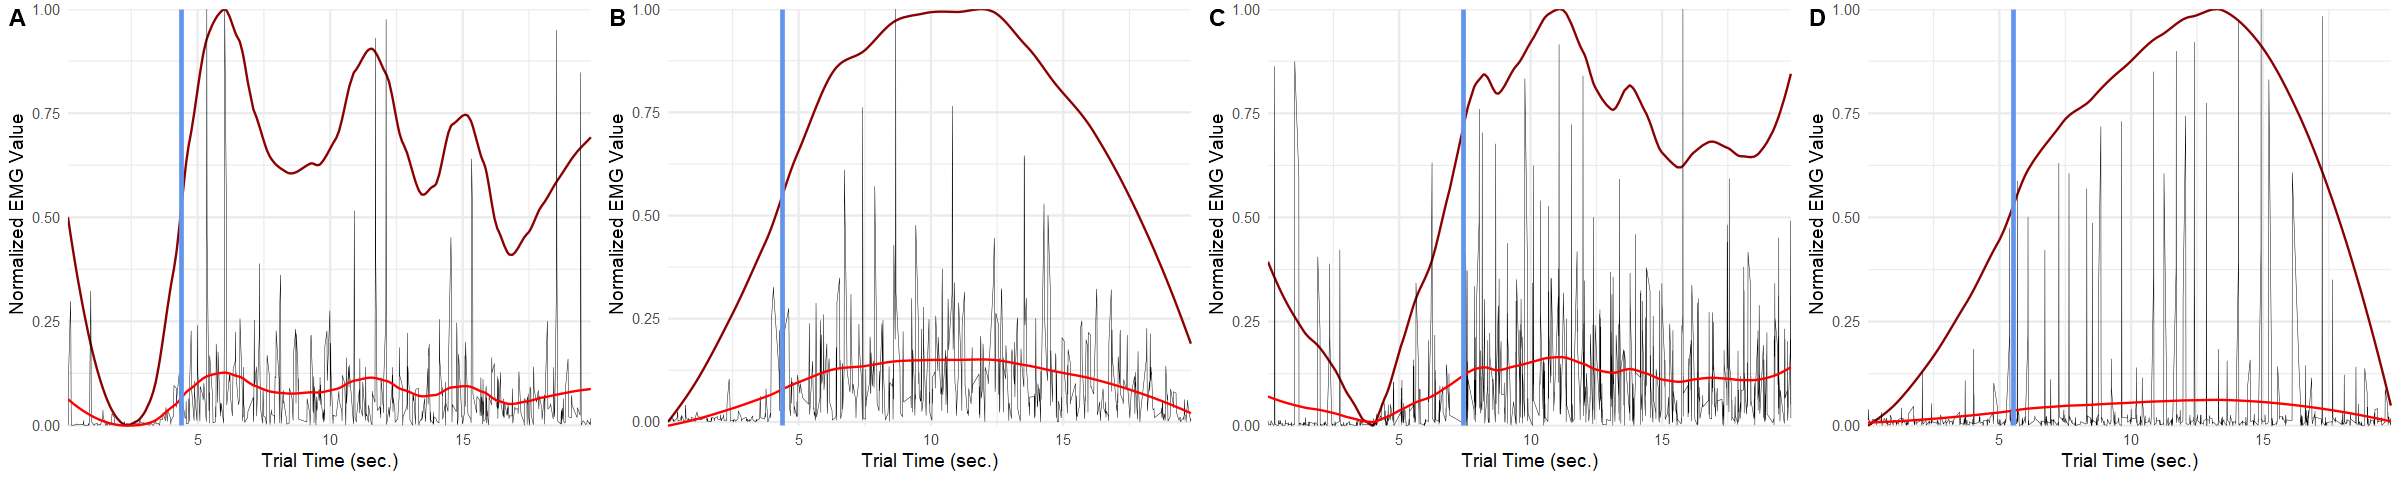

In [9]:
dataTrial <- "1"
dataModality <- "EMS"
dataTiming <- "11"
dataSubjectID <- "108"
dataMuscle <- "biceps"

plotA <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               coord_cartesian(expand = FALSE) +   
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")  +
               theme_minimal()
dataTrial <- "2"
dataModality <- "nothing"
dataTiming <- "11"
dataSubjectID <- "182"
dataMuscle <- "calf"

plotB <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               coord_cartesian(expand = FALSE) +  
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")   +
               theme_minimal()


dataTrial <- "2"
dataModality <- "Vibration"
dataTiming <- "5"
dataSubjectID <- "191"
dataMuscle <- "triceps"

plotC <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               coord_cartesian(expand = FALSE) +  
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")   +
               theme_minimal()


dataTrial <- "1"
dataModality <- "Visual"
dataTiming <- "11"
dataSubjectID <- "197"
dataMuscle <- "upperleg"

plotD <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1, color="black")  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") +   
               coord_cartesian(expand = FALSE) +  
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue") +
               theme_minimal()

options(repr.plot.width = 20, repr.plot.height = 4) 
plot <- ggarrange(plotA, plotB, plotC, plotD,
          labels = c("A", "B", "C", "D"),
          ncol = 4, nrow = 1)
plot
ggsave("ExamplesTKEOandBEDE.pdf", plot, width=14, height=3.5, device=cairo_pdf)

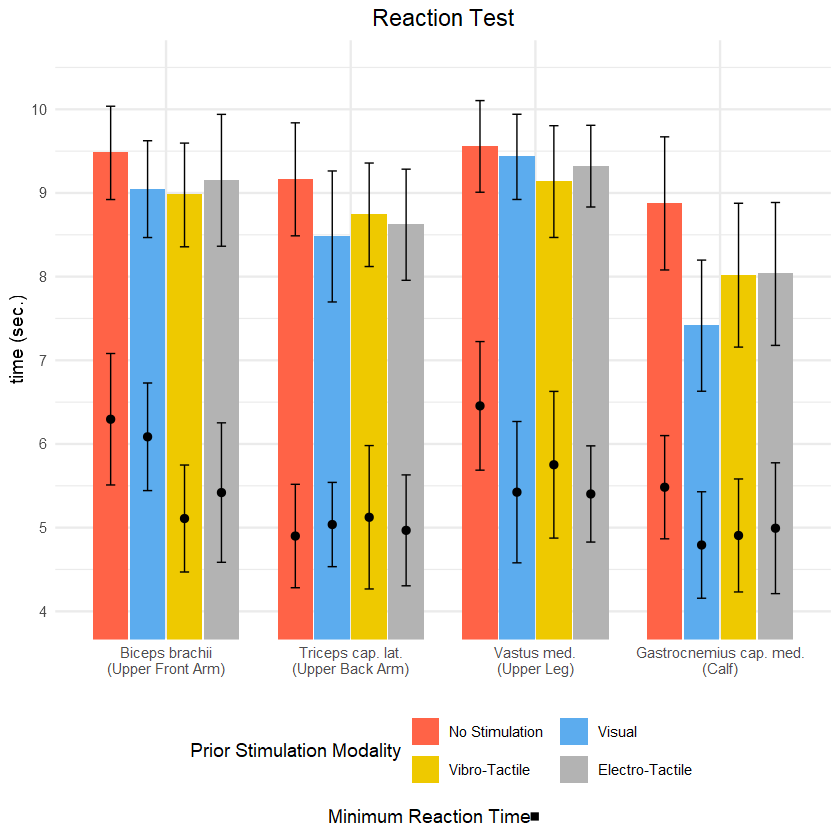

In [10]:
# we want to make it really, really beautiful

means <- timesPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(ReactionTime = mean(RT),
              ReactionTimeCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT) / sqrt(n()),
              ReactionTimeMin = mean(RTmin),
              ReactionTimeMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmin) / sqrt(n()),
              ReactionTimeMax = mean(RTmax),
              ReactionTimeMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmax) / sqrt(n()),
              ReactionTimeLog = mean(RTLog),
              ReactionTimeLogCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLog) / sqrt(n()),
              ReactionTimeLogMin = mean(RTLogmin),
              ReactionTimeLogMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLogmin) / sqrt(n()),
              ReactionTimeLogMax = mean(RTLogmax),
              ReactionTimeLogMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTLogmax) / sqrt(n()),
              N = n(),
              .groups = 'drop')  

means$Modality <- factor(means$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

means$Modality <- recode(means$Modality, nothing = "No Stimulation",
                                         Visual = "Visual",
                                         Vibration = "Vibro-Tactile",
                                         EMS = "Electro-Tactile")

means$Muscle <- recode(means$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

plot <- ggplot(means, aes(y=ReactionTime, x=Muscle, fill=Modality)) +  
                        geom_bar(stat = "identity", position = position_dodge(width = 0.8), width=0.75) + 
                        geom_errorbar(aes(ymin = ReactionTime - ReactionTimeCI, ymax = ReactionTime + ReactionTimeCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        scale_y_continuous(breaks = scales::breaks_width(1)) +
                        coord_cartesian(ylim=c(4,10.5)) +   
                        geom_point(aes(y=ReactionTimeMin, x=Muscle, shape = ""), size = 2, position = position_dodge(width = 0.8)) + 
                        geom_errorbar(aes(ymin = ReactionTimeMin - ReactionTimeMinCI, ymax = ReactionTimeMin + ReactionTimeMinCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) +  
                        ggtitle("Reaction Test") + 
                        ylab("time (sec.)") + 
                        xlab("") +  
                        labs(fill="Prior Stimulation Modality   ", shape = "Minimum Reaction Time") + 
                        theme_minimal()  + 
                       # geom_signif(comparisons=list(c("True", "False")), annotations="p = 0.033", y_position = 6.75, tip_length = 0.1, vjust=-0.6) +
                        scale_fill_manual(values = cbPalette) + 
                        guides(fill = guide_legend(nrow=2, byrow=TRUE, override.aes = list(shape = NA), order = 2), 
                               shape = guide_legend(nrow=1, override.aes = list(shape = c(15)), byrow=TRUE), order = 1) +
                        theme(
                            plot.title = element_text(hjust = 0.5),
                            legend.position="bottom",
                            legend.box="vertical",
                            legend.margin=margin()
                        )
                                         
options(repr.plot.width = 7, repr.plot.height = 7) 
plot

ggsave("ReactionTimes.pdf", plot, width=5, height=5, device=cairo_pdf)

In [11]:
# ANOVA for reactions times
aov <- anova_test(data = timesPerSubject, dv = RTLog, wid = SubjectID, within = c(Modality, Muscle), effect.size = "pes")

aov
get_anova_table(aov, correction = "GG") 

pairwise.t.test(timesPerSubject$RTLog, timesPerSubject$Modality, p.adj = "bonf", paired = TRUE)
pairwise.t.test(timesPerSubject$RTLog, timesPerSubject$Muscle, p.adj = "bonf", paired = TRUE)

ANOVA Table (type III tests)

$ANOVA
           Effect DFn DFd     F        p p<.05   pes
1        Modality   3  60 7.530 0.000234     * 0.274
2          Muscle   3  60 7.564 0.000226     * 0.274
3 Modality:Muscle   9 180 1.262 0.261000       0.059

$`Mauchly's Test for Sphericity`
           Effect     W     p p<.05
1        Modality 0.928 0.924      
2          Muscle 0.433 0.008     *
3 Modality:Muscle 0.100 0.721      

$`Sphericity Corrections`
           Effect   GGe       DF[GG]    p[GG] p[GG]<.05   HFe      DF[HF]
1        Modality 0.949  2.85, 56.96 0.000315         * 1.123 3.37, 67.41
2          Muscle 0.675  2.03, 40.51 0.002000         * 0.752 2.26, 45.11
3 Modality:Muscle 0.717 6.45, 129.05 0.277000           1.095 9.85, 197.1
     p[HF] p[HF]<.05
1 0.000234         *
2 0.000983         *
3 0.261000

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Modality,2.85,56.96,7.530,0.000315,*,0.274
2,Muscle,2.03,40.51,7.564,0.002000,*,0.274
3,Modality:Muscle,6.45,129.05,1.262,0.277000,,0.059



	Pairwise comparisons using paired t tests 

data:  timesPerSubject$RTLog and timesPerSubject$Modality 

          EMS    nothing Vibration
nothing   0.0155 -       -        
Vibration 1.0000 0.0036  -        
Visual    1.0000 0.0007  1.0000   

P value adjustment method: bonferroni 


	Pairwise comparisons using paired t tests 

data:  timesPerSubject$RTLog and timesPerSubject$Muscle 

         biceps  calf    triceps
calf     4.9e-05 -       -      
triceps  0.1157  0.0069  -      
upperleg 1.0000  1.3e-06 0.0153 

P value adjustment method: bonferroni 

Muscle,Modality,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
biceps,EMS,RTLogmin,0.972,0.784
biceps,nothing,RTLogmin,0.948,0.305
biceps,Vibration,RTLogmin,0.958,0.482
biceps,Visual,RTLogmin,0.988,0.992
calf,EMS,RTLogmin,0.966,0.636
calf,nothing,RTLogmin,0.986,0.986
calf,Vibration,RTLogmin,0.971,0.758
calf,Visual,RTLogmin,0.968,0.684
triceps,EMS,RTLogmin,0.945,0.274


ANOVA Table (type III tests)

$ANOVA
           Effect DFn DFd     F     p p<.05   pes
1        Modality   3  60 3.099 0.033     * 0.134
2          Muscle   3  60 5.404 0.002     * 0.213
3 Modality:Muscle   9 180 1.165 0.320       0.055

$`Mauchly's Test for Sphericity`
           Effect     W     p p<.05
1        Modality 0.931 0.930      
2          Muscle 0.652 0.157      
3 Modality:Muscle 0.034 0.113      

$`Sphericity Corrections`
           Effect   GGe       DF[GG] p[GG] p[GG]<.05   HFe       DF[HF] p[HF]
1        Modality 0.951  2.85, 57.08 0.036         * 1.126  3.38, 67.58 0.033
2          Muscle 0.835  2.51, 50.13 0.004         * 0.965  2.89, 57.89 0.003
3 Modality:Muscle 0.624 5.61, 112.25 0.331           0.895 8.05, 161.06 0.324
  p[HF]<.05
1         *
2         *
3

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Modality,3,60,3.099,0.033,*,0.134
2,Muscle,3,60,5.404,0.002,*,0.213
3,Modality:Muscle,9,180,1.165,0.320,,0.055


Muscle,Effect,DFn,DFd,F,p,p<.05,ges,p.adj
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
biceps,Modality,3,60,3.271,0.027,*,0.091,0.108
calf,Modality,3,60,1.624,0.193,,0.037,0.772
triceps,Modality,3,60,0.105,0.957,,0.003,1.000
upperleg,Modality,3,60,2.082,0.112,,0.064,0.448


,Muscle,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,biceps,RTLogmin,EMS,nothing,21,21,-1.7944243,20,0.088,0.527,ns
2,biceps,RTLogmin,EMS,Vibration,21,21,0.4086397,20,0.687,1.000,ns
3,biceps,RTLogmin,EMS,Visual,21,21,-2.4136906,20,0.025,0.153,ns
4,biceps,RTLogmin,nothing,Vibration,21,21,2.2895142,20,0.033,0.199,ns
5,biceps,RTLogmin,nothing,Visual,21,21,0.3128877,20,0.758,1.000,ns
6,biceps,RTLogmin,Vibration,Visual,21,21,-2.5563519,20,0.019,0.113,ns
7,calf,RTLogmin,EMS,nothing,21,21,-1.2556603,20,0.224,1.000,ns
8,calf,RTLogmin,EMS,Vibration,21,21,0.1115467,20,0.912,1.000,ns
9,calf,RTLogmin,EMS,Visual,21,21,0.4050856,20,0.690,1.000,ns


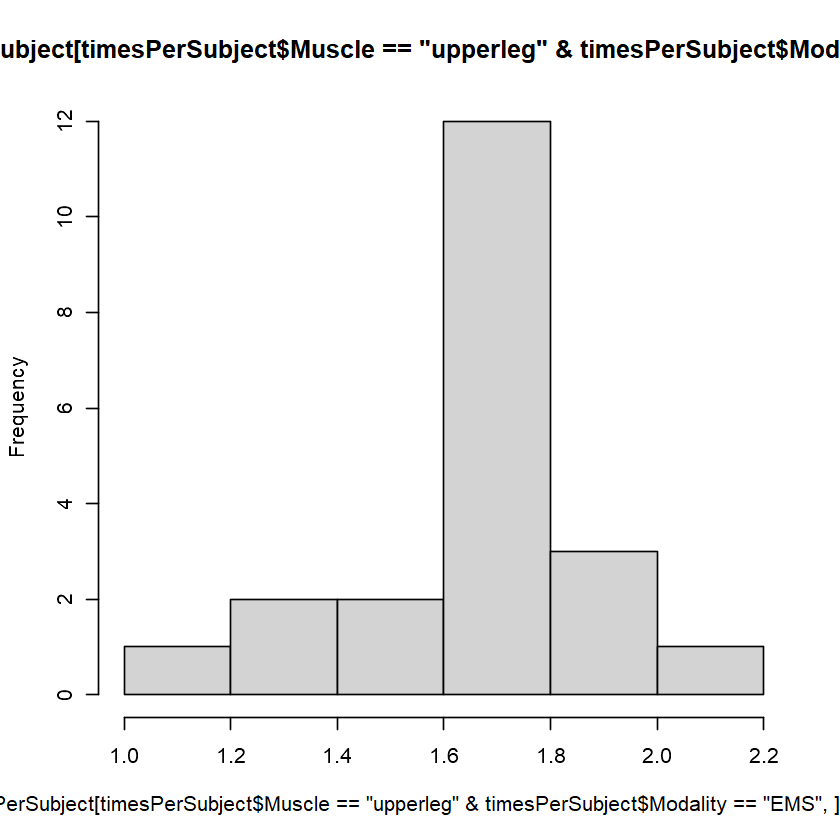

In [12]:
# ANOVA with the faster sample
round_df(timesPerSubject %>% group_by(Muscle, Modality) %>% shapiro_test(RTLogmin))

hist(timesPerSubject[timesPerSubject$Muscle == "upperleg" & timesPerSubject$Modality== "EMS",]$RTLogmin)

aov <- anova_test(data = timesPerSubject, dv = RTmin, wid = SubjectID, within = c(Modality, Muscle), effect.size = "pes")
aov
get_anova_table(aov, correction = "auto") 

# Interaction effect, we must look into the muscles
timesPerSubject %>% group_by(Muscle) %>% anova_test(dv = RTLogmin, wid = SubjectID, within = Modality) %>% get_anova_table() %>% adjust_pvalue(method = "bonferroni")

# biceps and upperleg are significant. let's do the t-tests
timesPerSubject %>% group_by(Muscle) %>% pairwise_t_test(RTLogmin ~ Modality, paired = TRUE, p.adjust.method = "bonferroni" )

In [13]:
# egal

aov <- anova_test(data = timesPerSubject, dv = RTmax, wid = SubjectID, within = c(Muscle, Modality), effect.size = "pes")
get_anova_table(aov, correction = "auto") 

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Muscle,2.04,40.90,2.230,0.119,,0.100
2,Modality,2.11,42.19,2.105,0.132,,0.095
3,Muscle:Modality,9.00,180.00,1.372,0.204,,0.064


,trialTimeS,Muscle,Modality,EMGValue,EMGValueNormalized,EMGTKEOValue,EMGTKEOValueNormalized,EMGSmoothedValueNormalized
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,biceps,EMS,32941.37,0.4866800,40764559,0.03304018,0.2919145
2,2,biceps,EMS,32973.94,0.4958277,51177365,0.04372243,0.2632798
3,3,biceps,EMS,32888.43,0.5019589,42930877,0.03754979,0.2955659
4,4,biceps,EMS,32924.80,0.5049124,38006388,0.03266593,0.2977565
5,5,biceps,EMS,32984.21,0.5159479,29461095,0.02522184,0.2624633
6,6,biceps,EMS,32651.30,0.5057698,26697930,0.02350418,0.2268241


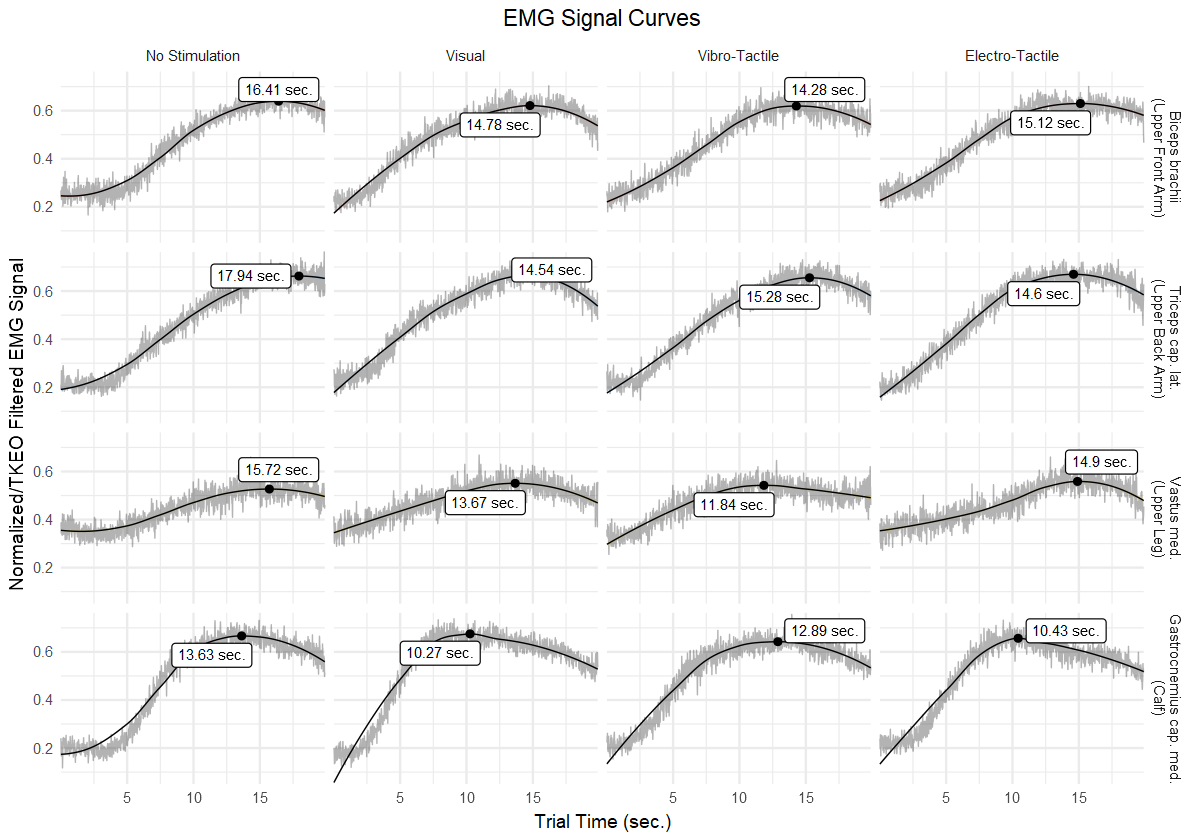

In [14]:
# the world is not enough, we need precise inflections points

inflectionPoint <- function(x, y) {
    xl <- seq(min(x), max(x), (max(x) - min(x)) / 1000)
    suppressWarnings( out <- predict(loess(y~x), xl))
    infl <- c(FALSE, diff(diff(out)>0) != 0)
    c(tail(xl[infl], n=1), tail(out[infl], n = 1))
}   
 
data$trialTimeS <- round(data$trialTime, 2) 

meanData <- aggregate(cbind(EMGValue, EMGValueNormalized, EMGTKEOValue, EMGTKEOValueNormalized, EMGSmoothedValueNormalized) ~ as.factor(trialTimeS) + Muscle + Modality, data[(data$trialTimeS) < 19.9, ], mean)
colnames(meanData) <- c("trialTimeS", "Muscle","Modality", "EMGValue", "EMGValueNormalized", "EMGTKEOValue", "EMGTKEOValueNormalized", "EMGSmoothedValueNormalized")
meanData$trialTimeS <- as.numeric(meanData$trialTimeS)
#head(data)
head(meanData)

df <- meanData %>% group_by(Muscle, Modality) %>% mutate(x1 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[1],
                                                         x2 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[2])
df <- aggregate(cbind(df$x1, df$x2), by=list(df$Muscle, df$Modality), mean)

df <- do.call(data.frame, df)
colnames(df) <- c("Muscle", "Modality", "trialTimeS", "EMGSmoothedValueNormalized") 

df$Modality <- factor(df$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
df$Muscle <- factor(df$Muscle, levels = c("biceps", "triceps", "upperleg", "calf")) 

df$Modality <- recode(df$Modality, nothing = "No Stimulation",
                                         Visual = "Visual",
                                         Vibration = "Vibro-Tactile",
                                         EMS = "Electro-Tactile")

df$Muscle <- recode(df$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

meanData$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
meanData$Muscle <- factor(meanData$Muscle, levels = c("biceps", "triceps", "upperleg", "calf")) 

meanData$Modality <- recode(meanData$Modality, nothing = "No Stimulation",
                                         Visual = "Visual",
                                         Vibration = "Vibro-Tactile",
                                         EMS = "Electro-Tactile")

meanData$Muscle <- recode(meanData$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

# beautiful TKEO corrected sample 
plot <- ggplot(meanData, aes(x = trialTimeS/ 100, y = EMGSmoothedValueNormalized, color = Muscle, fill = Muscle)) +  
            facet_grid(Muscle ~ Modality) + 
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
            #scale_x_continuous(breaks = scales::breaks_width(5)) +
            #coord_cartesian(xlim = c(0, 20), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(0.1), limits=c(0,0.3)) +
            geom_line(size = 0.3, alpha = .3, color = "black") + 
            geom_smooth(data = meanData, size = 0.3, method = 'loess', formula = "y ~ x", color = "black") +
            #geom_smooth() +
            coord_cartesian(expand = FALSE) +  
            geom_point(data = df, color = "black") + 
            ggtitle("EMG Signal Curves") + 
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            geom_label_repel(data = df, label = paste("",round(df$trialTimeS/ 100, 2),"~sec."), fill="white", color = "black", size=3, show.legend = FALSE, parse = TRUE) + #, "plain('sec')~italic('|')", round(df$EMGSmoothedValueNormalized, 2), " max.", sep="~"
            ylab("Normalized/TKEO Filtered EMG Signal") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Trial Time (sec.)") +  
            scale_color_manual(values = cbPalette) +
            scale_fill_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "none"
            ) 
options(repr.plot.width = 10, repr.plot.height = 7) 
plot
ggsave("ReactionCurves.pdf", plot, width=10, height=7, device=cairo_pdf)

In [15]:
# we want to do this for each trial to do an ANOVA on each saddle (maximum signal strength)

inflectionPoint <- function(x, y) {
    xl <- seq(min(x), max(x), (max(x) - min(x)) / 1000)
    suppressWarnings( out <- predict(loess(y~x), xl))
    infl <- c(FALSE, diff(diff(out)>0) != 0)
    c(tail(xl[infl], n=1), tail(out[infl], n = 1))
}   
 
data$trialTimeS <- round(data$trialTime, 2) 

meanData <- aggregate(cbind(EMGValue, EMGValueNormalized, EMGTKEOValue, EMGTKEOValueNormalized, EMGSmoothedValueNormalized) ~ SubjectID + Muscle + Modality + as.factor(trialTimeS), data[(data$trialTimeS) < 19.9, ], mean)
colnames(meanData) <- c("SubjectID", "Muscle","Modality", "trialTimeS", "EMGValue", "EMGValueNormalized", "EMGTKEOValue", "EMGTKEOValueNormalized", "EMGSmoothedValueNormalized")
meanData$trialTimeS <- as.numeric(meanData$trialTimeS)
#head(data)

df <- meanData %>% group_by(SubjectID, Muscle, Modality) %>% mutate(x1 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[1],
                                                                    x2 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[2])
length(is.na(df))
head(df)

dfPerSubject <- aggregate(cbind(df$x1, df$x2), by=list(df$SubjectID, df$Muscle, df$Modality), mean)

dfPerSubject <- do.call(data.frame, dfPerSubject)
colnames(dfPerSubject) <- c("SubjectID", "Muscle", "Modality", "trialTimeS", "EMGSmoothedValueNormalized")
head(dfPerSubject)

[1] 7222996

SubjectID,Muscle,Modality,trialTimeS,EMGValue,EMGValueNormalized,EMGTKEOValue,EMGTKEOValueNormalized,EMGSmoothedValueNormalized,x1,x2
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
186,biceps,EMS,1,33466.75,0.5363896,89689067,0.055000969,0.20624408,1235.548,0.7785860
187,biceps,EMS,1,33178.06,0.5105440,38406246,0.034858922,0.14496552,1344.888,0.7327075
188,biceps,EMS,1,33605.50,0.5260163,103392071,0.076394003,0.36263611,1219.644,0.4583470
189,biceps,EMS,1,32585.82,0.3299720,24877943,0.021009409,0.08059223,1297.176,0.7287830
190,biceps,EMS,1,32904.18,0.4483009,8010561,0.006884912,0.34167800,NA,NA
191,biceps,EMS,1,32083.39,0.4744323,74066346,0.058372341,0.07273817,NA,NA


,SubjectID,Muscle,Modality,trialTimeS,EMGSmoothedValueNormalized
,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,106,biceps,EMS,1581.665,0.7063810
2,107,biceps,EMS,1520.068,0.5477397
3,108,biceps,EMS,1019.344,0.7732556
4,109,biceps,EMS,1563.782,0.7341846
5,111,biceps,EMS,1541.925,0.8359520
6,182,biceps,EMS,1477.598,0.7915966


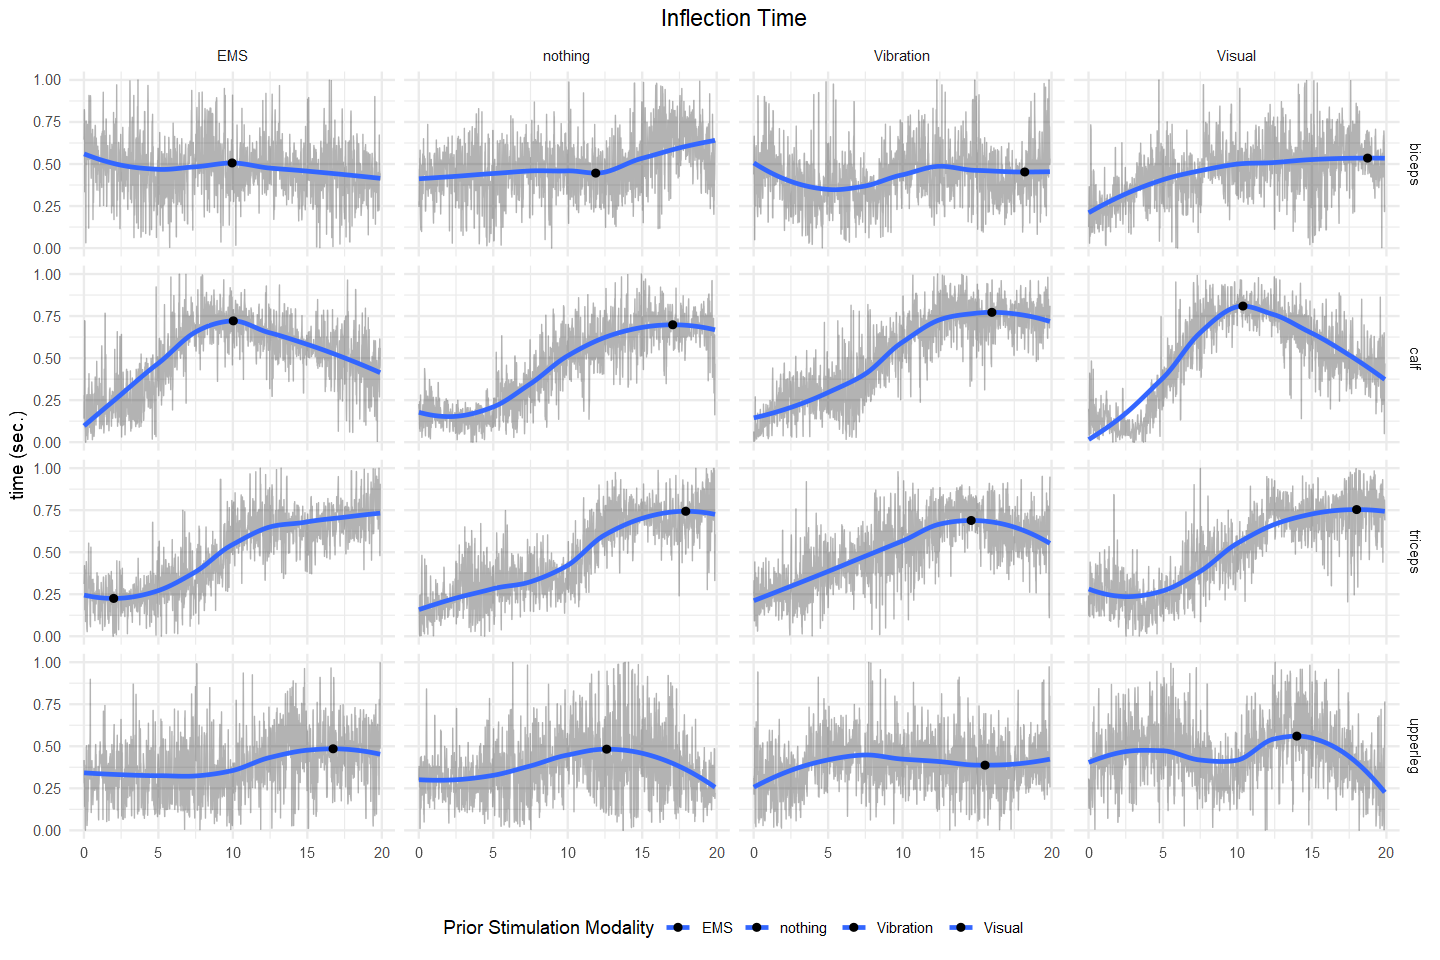

In [16]:
plot <- ggplot(meanData[meanData$SubjectID == "193",], aes(y=EMGSmoothedValueNormalized, x=trialTimeS / 100, fill=Modality)) +  
                        facet_grid(Muscle ~ Modality) + 
                        #geom_bar(stat = "identity", position = position_dodge(width = 0.8), width=0.75) + 
                        #geom_errorbar(aes(ymin = EMGInflection - EMGInflectionCI, ymax = EMGInflection + EMGInflectionCI),
                                      #width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        geom_line(size = 0.3, alpha = .3, color = "black") + 
                        geom_smooth(method = 'loess', formula = "y ~ x", se = FALSE) +
                        #scale_y_continuous(breaks = scales::breaks_width(1)) +
                        #coord_cartesian(ylim=c(4,11)) +   
                       # geom_point(data = maxResult[maxResult$SubjectID == "193",], color = "red") + 
                        geom_point(data = dfPerSubject[dfPerSubject$SubjectID == "193",], color = "black") +  
                        ggtitle("Inflection Time") + 
                        ylab("time (sec.)") + 
                        xlab("") +  
                        labs(fill="Prior Stimulation Modality   ", shape = NULL) +
                        theme_minimal()  + 
                       # geom_signif(comparisons=list(c("True", "False")), annotations="p = 0.033", y_position = 6.75, tip_length = 0.1, vjust=-0.6) +
                        scale_fill_manual(values = cbPalette) +
                        theme(
                            plot.title = element_text(hjust = 0.5),
                            legend.position="bottom"
                        )
                                         
options(repr.plot.width = 12, repr.plot.height = 8) 
plot


SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized,EMGSmoothedValue,minEMGSmoothedValue,maxEMGSmoothedValue,EMGSmoothedValueNormalized,trialTimeS
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,33991,29873,32917,32098,⋯,45327,18077,974932335,0.6509315,0.01606112,0.12688684,-0.008727329,0.12688684,1,14.45
106,biceps,EMS,13,1,6.382124e+17,33214,28208,29505,39216,⋯,43684,20545,830612456,0.5883463,0.01728730,0.07419394,0.016977909,0.07419394,1,13.76
106,biceps,EMS,3,1,6.382123e+17,42628,37938,32916,32484,⋯,43478,0,820407580,0.9381188,0.85992716,0.11201827,0.020249972,0.11201827,1,19.82
106,biceps,EMS,5,1,6.382123e+17,31330,32387,32742,32338,⋯,47943,29554,1245533365,0.4642869,0.03517457,0.08609797,-0.001055385,0.08609797,1,16.34
106,biceps,EMS,7,1,6.382124e+17,32854,32893,32948,32231,⋯,44650,25601,1000637625,0.6359484,0.00328890,0.12857253,0.033781275,0.12857253,1,0.11
106,biceps,EMS,9,1,6.382124e+17,47056,38086,32798,32742,⋯,47056,5476,1148892334,1.0000000,1.00000000,0.13072181,-0.007952488,0.13072181,1,19.81


Muscle,Modality,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
biceps,EMS,RTLog,0.833,0.002
biceps,nothing,RTLog,0.925,0.108
biceps,Vibration,RTLog,0.967,0.676
biceps,Visual,RTLog,0.953,0.387
calf,EMS,RTLog,0.965,0.615
calf,nothing,RTLog,0.918,0.080
calf,Vibration,RTLog,0.936,0.178
calf,Visual,RTLog,0.984,0.970
triceps,EMS,RTLog,0.938,0.202


ANOVA Table (type III tests)

$ANOVA
           Effect DFn DFd      F        p p<.05   pes
1        Modality   3  60  2.720 5.20e-02       0.120
2          Muscle   3  60 10.939 7.92e-06     * 0.354
3 Modality:Muscle   9 180  1.483 1.57e-01       0.069

$`Mauchly's Test for Sphericity`
           Effect     W     p p<.05
1        Modality 0.744 0.355      
2          Muscle 0.508 0.027     *
3 Modality:Muscle 0.021 0.029     *

$`Sphericity Corrections`
           Effect   GGe      DF[GG]    p[GG] p[GG]<.05   HFe      DF[HF]
1        Modality 0.857 2.57, 51.41 6.20e-02           0.994 2.98, 59.65
2          Muscle 0.763 2.29, 45.75 6.78e-05         * 0.866  2.6, 51.98
3 Modality:Muscle 0.567 5.1, 102.01 2.01e-01           0.784 7.05, 141.1
     p[HF] p[HF]<.05
1 5.30e-02          
2 2.64e-05         *
3 1.77e-01

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Modality,3.00,60.00,2.720,0.052,,0.120
2,Muscle,2.29,45.75,10.939,0.000,*,0.354
3,Modality:Muscle,5.10,102.01,1.483,0.201,,0.069



	Pairwise comparisons using Wilcoxon signed rank test with continuity correction 

data:  meansPerSubject$RTLog and meansPerSubject$Modality 

          EMS   nothing Vibration
nothing   0.288 -       -        
Vibration 1.000 0.073   -        
Visual    0.808 0.014   1.000    

P value adjustment method: bonferroni 


	Pairwise comparisons using Wilcoxon signed rank test with continuity correction 

data:  meansPerSubject$RTLog and meansPerSubject$Muscle 

         biceps  calf    triceps
calf     0.00017 -       -      
triceps  1.00000 9.0e-05 -      
upperleg 1.6e-06 1.00000 7.6e-06

P value adjustment method: bonferroni 

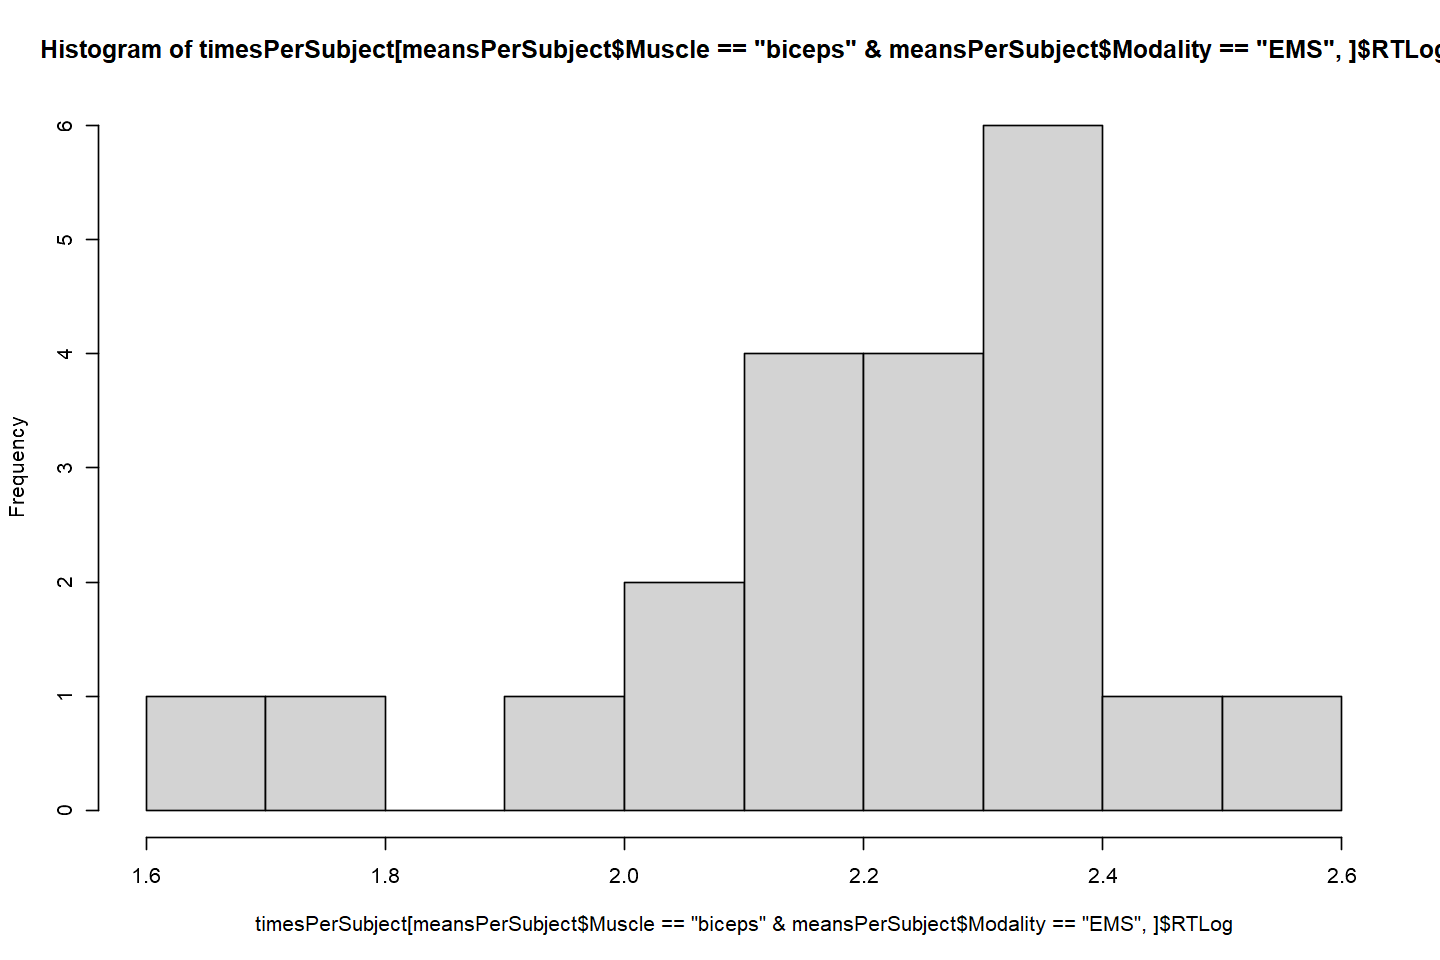

In [17]:
# we want to have the time at the maximum value of the smoothed signal

maxResult <- data[(data$trialTimeS) < 19.9, ] %>% group_by(SubjectID, Muscle, Modality, Trial, Timing) %>% arrange(desc(EMGSmoothedValueNormalized)) %>% slice(1) %>% ungroup()
head(maxResult)

meansPerSubject <- na.omit(maxResult) %>% group_by(SubjectID, Muscle, Modality) %>% 
    summarize(RT = mean(trialTimeS),
              RTLog = log(mean(trialTimeS)),
              N = n(),
              .groups = 'drop')   

round_df(meansPerSubject %>% group_by(Muscle, Modality) %>% shapiro_test(RTLog))

aov <- anova_test(data = meansPerSubject, dv = RTLog, wid = SubjectID, within = c(Modality,Muscle), effect.size = "pes")
aov
round_df(get_anova_table(aov, correction = "auto") )

#m = art(RTLog ~ Muscle * Modality + (1|SubjectID), data=meansPerSubject) # linear mixed model syntax; see lme4::lmer
#round_df(anova(m))

hist(timesPerSubject[meansPerSubject$Muscle == "biceps" & meansPerSubject$Modality== "EMS",]$RTLog)

pairwise.wilcox.test(meansPerSubject$RTLog, meansPerSubject$Modality, p.adj = "bonf", paired = TRUE)
pairwise.wilcox.test(meansPerSubject$RTLog, meansPerSubject$Muscle, p.adj = "bonf", paired = TRUE)

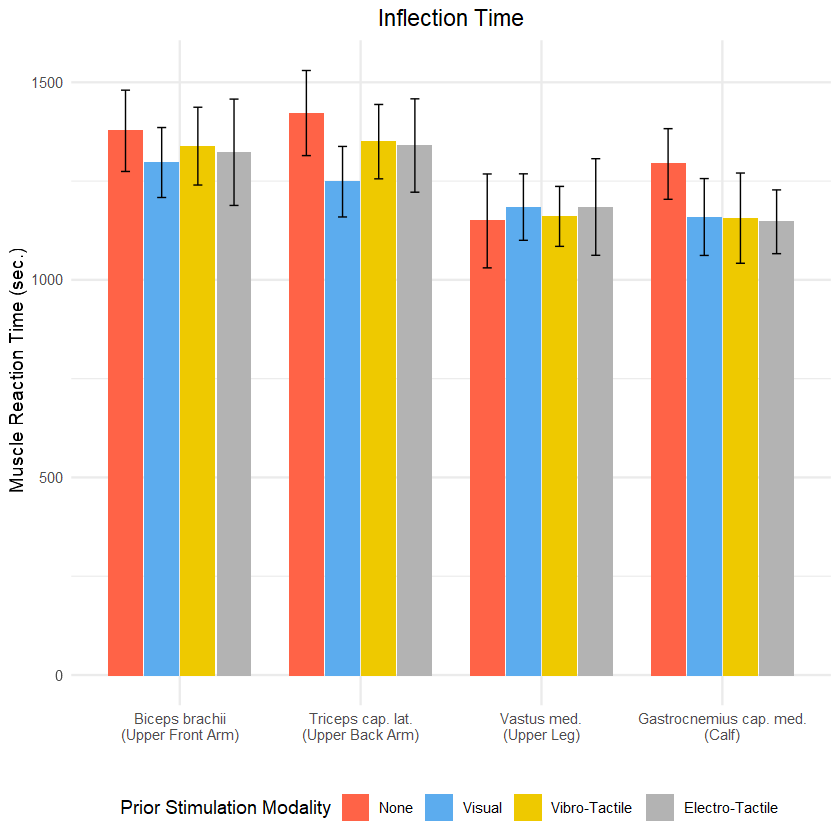

In [18]:
means <- meansPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(EMGInflection = mean(RT * 100),
              EMGInflectionCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT * 100) / sqrt(n()), 
              N = n(),
              .groups = 'drop')   

means$Modality <- factor(means$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

means$Modality <- recode(means$Modality, nothing = "None",
                                         Visual = "Visual",
                                         Vibration = "Vibro-Tactile",
                                         EMS = "Electro-Tactile")

means$Muscle <- recode(means$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

plot <- ggplot(means, aes(y=EMGInflection, x=Muscle, fill=Modality)) +  
                        geom_bar(stat = "identity", position = position_dodge(width = 0.8), width=0.75) + 
                        geom_errorbar(aes(ymin = EMGInflection - EMGInflectionCI, ymax = EMGInflection + EMGInflectionCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        #scale_y_continuous(breaks = scales::breaks_width(1)) +
                        #coord_cartesian(ylim=c(4,11)) +   
                        ggtitle("Inflection Time") + 
                        ylab("Muscle Reaction Time (sec.)") + 
                        xlab("") +  
                        labs(fill="Prior Stimulation Modality   ", shape = NULL) +
                        theme_minimal()  + 
                       # geom_signif(comparisons=list(c("True", "False")), annotations="p = 0.033", y_position = 6.75, tip_length = 0.1, vjust=-0.6) +
                        scale_fill_manual(values = cbPalette) +
                        theme(
                            plot.title = element_text(hjust = 0.5),
                            legend.position="bottom"
                        )
                                         
options(repr.plot.width = 7, repr.plot.height = 7) 
plot

ggsave("EMGInflectionTimes.pdf", plot, width=7, height=7, device=cairo_pdf)

# don't put this into this paper, looks ugly :)

In [19]:
# Do Amplitude and Reaction Time change over time?
library(nlme)
library(MuMIn)

findBulgeStart <- function(x, y){
    cc <- check_curve(x, y) 
    ipbede <- bede(x, y, cc$index)
    #ipbede <- ifelse(!is.na(ipbede), ipbede, 20)
    return(as.numeric(ipbede$iplast))
}

timesAndAmpsPerSubject <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% 
    summarize(ReactionTime = findBulgeStart(trialTime, EMGSmoothedValueNormalized),
              EMGAmplitude = mean(EMGSmoothedValueNormalized),
              ExperimentTime = max(experimentTime),
              .groups = 'drop') 

timesAndAmpsPerSubject <- na.omit(timesAndAmpsPerSubject) 

lm <- lme(ReactionTime ~ ExperimentTime * Muscle,random=~1|SubjectID,  timesAndAmpsPerSubject)
r.squaredGLMM(lm)
r.
summary(lm)
round_df(anova(lm))


lm <- lme(EMGAmplitude ~ ExperimentTime * Muscle,random=~1|SubjectID,  timesAndAmpsPerSubject)
r.squaredGLMM(lm)
summary(lm)
round_df(anova(lm))


round_df(timesAndAmpsPerSubject %>% group_by(Muscle) %>% cor_test(ReactionTime, EMGAmplitude))

plotVals <- melt(timesAndAmpsPerSubject, id.vars = c("SubjectID", "Muscle", "Modality", "Timing", "Trial", "ExperimentTime"),
                                   measure.vars = c("ReactionTime", "EMGAmplitude"))

colnames(plotVals) <- c("SubjectID", "Muscle", "Modality","Timing","Trial","ExperimentTime","Measure","Value")

plotVals <- aggregate(Value ~ SubjectID + Muscle + ExperimentTime + Measure, plotVals, mean)
plotVals <- do.call(data.frame, plotVals)
colnames(plotVals) <- c("SubjectID", "Muscle", "ExperimentTime","Measure","Value")
plotVals$ExperimentTime <- as.numeric(plotVals$ExperimentTime)
head(plotVals)

levels(plotVals$Measure) <- c("Reaction Time (in sec.)", "Normalized EMG Amplitude")

plotVals$Muscle <- factor(plotVals$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

plotVals$Muscle <- recode(plotVals$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)")  


Attache Paket: 'nlme'


Das folgende Objekt ist maskiert 'package:lme4':

    lmList


Das folgende Objekt ist maskiert 'package:dplyr':

    collapse


Warning message:
"'r.squaredGLMM' now calculates a revised statistic. See the help page."


R2m,R2c
0.03074002,0.08715713


ERROR: Error in eval(expr, envir, enclos): Objekt 'r.' nicht gefunden


In [ ]:
# Plot Amplitude and Reaction Time together

plot <- ggplot(plotVals, aes(x = ExperimentTime / 600, y = Value, color = Muscle, fill = Muscle)) +   
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
            facet_wrap(.~Measure, scales = "free")+
            scale_x_continuous(breaks = scales::breaks_width(5)) + 
            coord_cartesian(xlim=c(0,64), expand = FALSE) +   
            #scale_y_continuous(breaks = scales::breaks_width(1), limits=c(6,11)) +
            #geom_line(size = 0.6) + 
            geom_point(data = plotVals[plotVals$Measure == "Reaction Time (in sec.)" & plotVals$Value > 6.5 & plotVals$Value < 10.5,], alpha = 0.5, size = 0.1) + 
            geom_point(data = plotVals[plotVals$Measure == "Normalized EMG Amplitude" & plotVals$Value > 0.4 & plotVals$Value < 0.575,], alpha = 0.5, size = 0.1) + 
            geom_smooth(method = 'lm', alpha = 1, size = 0.4, formula = "y~x", se = FALSE, show.legend = FALSE) +
            geom_smooth(method = 'loess', alpha = 0.1, size = 0.3, formula = "y~x", linetype = "dashed") +
            geom_smooth(method = 'loess', alpha = 1, size = 0.4, formula = "y~x", linetype = "dashed", se = FALSE, show.legend = FALSE) +
            ggtitle("Learning vs Fatigue") +
            #geom_wrap(.~Muscle) + 
            #labs(fill = "", color = "") +
            ylab("") +  
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            guides(fill = "none") +
            labs(color="", shape = "Minimum Reaction Time") + 
            scale_color_manual(values = cbPalette) +
            scale_fill_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom",
                axis.title.y = element_blank()
            ) 
options(repr.plot.width = 10, repr.plot.height = 4) 
plot
ggsave("FatigueVSLearning.pdf", plot, width=10, height=4, device=cairo_pdf)

In [ ]:
plotValsFct <- na.omit(plotVals)
plotValsFct$ExperimentTime <- as.factor(round(plotValsFct$ExperimentTime / 6000, 0))  
head(plotValsFct)
levels(plotValsFct$ExperimentTime)

#aov <- anova_test(data = plotValsFct[plotValsFct$Measure == "Reaction Time (in sec.)",], dv = Value, wid = SubjectID, within = c(ExperimentTime, Muscle),  effect.size = "pes")
#round_df(get_anova_table(aov, correction = "auto") ) 

print("ANOVA on Reaction Time with Experiment Time as Continous Factor")
aov <- aov(Value ~ ExperimentTime * Muscle + Error(SubjectID / (ExperimentTime + Muscle)), plotValsFct[plotValsFct$Measure == "Reaction Time (in sec.)",])
summary(aov) 


print("ANOVA on Amplitude with Experiment Time as Continous Factor")
aov <- aov(Value ~ ExperimentTime * Muscle + Error(SubjectID / (ExperimentTime + Muscle)), plotValsFct[plotValsFct$Measure == "Normalized EMG Amplitude",])
summary(aov) 
#aov <- anova_test(data = plotValsFct[plotValsFct$Measure == "Normalized EMG Amplitude",], dv = Value, wid = SubjectID, between = c(ExperimentTime, Muscle),  effect.size = "pes")
#round_df(get_anova_table(aov, correction = "auto") ) 

In [ ]:
plotValsFct[plotValsFct$Measure == "Reaction Time (in sec.)",]

In [ ]:


 
means <- plotValsFct %>% group_by(Muscle, ExperimentTime, Measure) %>% summarize(
    Mean = mean(Value),
    MeanSD = sd(Value),
    N = n(), .groups = 'drop',) %>% mutate(
    MeanSE = MeanSD / sqrt(N),
    MeanCI = qt(1 - (0.05 / 2), N - 1) * MeanSE) 
 
means$ExperimentTime <- as.numeric(means$ExperimentTime)  
head(means)


plot <- ggplot(means, aes(x = ExperimentTime * 10, y = Mean, color = Muscle, fill = Muscle)) +   
            facet_wrap(.~Measure, scales = "free")+
            geom_errorbar(aes(ymin = Mean - MeanCI, ymax = Mean + MeanCI), width=1, alpha=0.5, size=0.5) +  
            scale_x_continuous(breaks = scales::breaks_width(10)) + 
            #coord_cartesian(ylim = c(6, 11), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(1), limits=c(6,11)) +
            geom_line() + 
            geom_point() +  
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            ylab("Reaction Time (sec.)") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            #labs(color="Task", linetype="Room") + 
            scale_color_manual(values = cbPalette) +
            theme_minimal() + 
            labs(fill = "", color = "") +
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 10, repr.plot.height = 4) 
plot
ggsave("FatigueVSLearningDiscrete.pdf", plot, width=10, height=4, device=cairo_pdf)

In [ ]:
library(e1071)

In [ ]:
svmfit = svm(EMGSmoothedValueNormalized ~ Muscle, data = data, kernel = "linear", cost = 10, scale = FALSE)
print(svmfit)

In [21]:
nrow(data)

[1] 3829569

In [ ]:
svmData <- data.frame(scale(theData[,34:70]))
svmData$Face <- theData$latinSquare

set.seed(101)
sample <- sample.int(n = nrow(svmData), size = floor(.80*nrow(svmData)), replace = F)
train <- svmData[sample, ]
test  <- svmData[-sample, ]